In [ ]:
import torch, numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

DEVICE        = 'cpu' 
T             = 500        # diffusion steps
BATCH_SIZE    = 512
TRAIN_ITERS   = 2000       # 訓練步數
LR            = 5e-4
HIDDEN        = 512
TIME_DIM      = 64
N_TRAIN_SAMP  = 10000       # 訓練資料量）
### Constants setting
betas = torch.linspace(1e-4, 0.02, T+1, device=DEVICE)
alphas = 1.0-betas
abar = torch.cumprod(alphas, dim=0)
sqrt_abar = torch.sqrt(abar)
sqrt_lmabar = torch.sqrt(1.0-abar)
sqrt_rcp_a = torch.sqrt(1.0 / alphas)


<class 'torch.Tensor'> torch.Size([10000, 1]) cpu


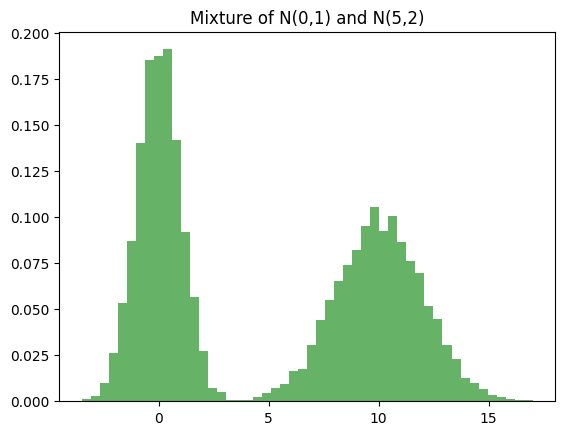

In [11]:
# 定義兩個 normal distribution
mu1, sigma1 = 0, 1   # N(0, 1)
mu2, sigma2 = 10, 2   # N(10, 2)

n_samples = 10000
weights = [0.5, 0.5]  # mixture ratio

# 先決定每個樣本從哪個分布來
choices = np.random.choice([0, 1], size=n_samples, p=weights)

# 依據 choices 產生樣本
samples = np.where(
    choices == 0,
    np.random.normal(mu1, sigma1, n_samples),
    np.random.normal(mu2, sigma2, n_samples)
)
# samples 是一維 numpy.ndarray，長度 n_samples
y0 = torch.tensor(samples, dtype=torch.float32, device=DEVICE).unsqueeze(1)  # 變成 (N,1)
print(type(y0), y0.shape, y0.device)  # 應該是 torch.Tensor, (10000, 1), cpu/cuda


# 畫圖
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g')
plt.title("Mixture of N(0,1) and N(5,2)")
plt.show()

[train] step    1 | loss 1.022105
[train] step    2 | loss 0.954555
[train] step    3 | loss 0.951049
[train] step    4 | loss 0.908865
[train] step    5 | loss 0.926673
[train] step    6 | loss 0.874764
[train] step    7 | loss 0.870203
[train] step    8 | loss 0.857677
[train] step    9 | loss 0.725886
[train] step   10 | loss 0.762656
[train] step   11 | loss 0.813631
[train] step   12 | loss 0.781375
[train] step   13 | loss 0.751414
[train] step   14 | loss 0.607102
[train] step   15 | loss 0.636189
[train] step   16 | loss 0.617659
[train] step   17 | loss 0.640117
[train] step   18 | loss 0.604063
[train] step   19 | loss 0.529884
[train] step   20 | loss 0.494416
[train] step   21 | loss 0.503928
[train] step   22 | loss 0.476214
[train] step   23 | loss 0.498542
[train] step   24 | loss 0.535493
[train] step   25 | loss 0.459014
[train] step   26 | loss 0.460010
[train] step   27 | loss 0.527894
[train] step   28 | loss 0.562621
[train] step   29 | loss 0.503972
[train] step  

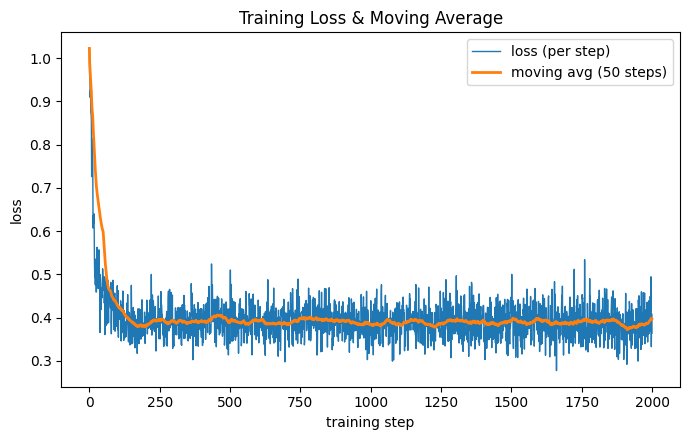

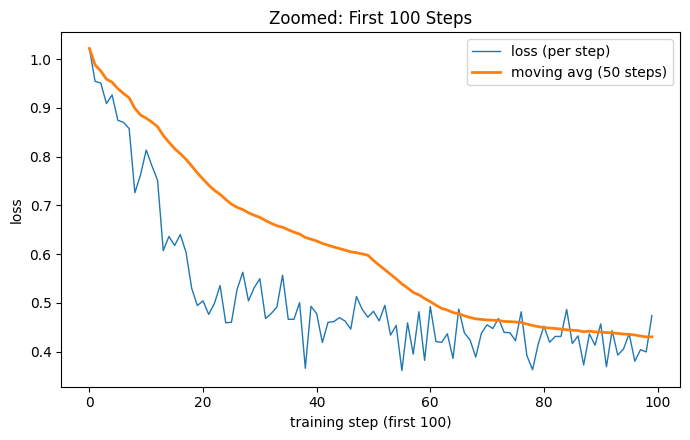

<class 'torch.optim.adamw.AdamW'>
group 0 lr=0.0005
y_hat:  tensor([ 1.1022e+00, -2.0492e-01, -6.8705e-01, -1.3909e+00,  1.2172e+00,
        -1.1299e+00, -9.8437e-02, -1.7627e-01, -5.6460e-01, -4.4429e-01,
        -3.1924e-01, -1.0141e+00, -1.3873e+00, -2.3077e-01,  1.2606e+00,
         1.8639e-01, -1.1180e-01,  4.2162e-01,  6.1158e-01,  1.4229e+00,
         1.9060e-01,  1.0179e+00,  2.8056e-01, -1.8746e+00, -1.1701e+00,
        -1.7069e+00,  5.3024e-01, -8.7758e-01, -2.8148e-01,  4.4762e-01,
        -2.4233e-01,  1.0928e+00, -9.5005e-01,  1.1579e+00,  9.0407e-01,
        -1.5574e+00,  1.0804e+00,  1.1338e+00, -9.1384e-02, -2.3578e+00,
         1.5205e+00, -5.2435e-01,  6.4733e-01, -2.1679e-01,  5.3246e-01,
        -6.2413e-01, -4.4475e-01,  1.2658e+00,  5.7050e-01, -1.5308e+00,
         2.0016e+00,  9.2701e-01, -4.3535e-01, -1.8454e+00, -1.7261e-01,
        -7.4434e-01,  1.4380e+00,  4.0293e-01, -7.4711e-01, -6.4080e-01,
        -1.4935e+00, -1.2357e+00, -2.6093e-01,  1.3081e+00, -1.7

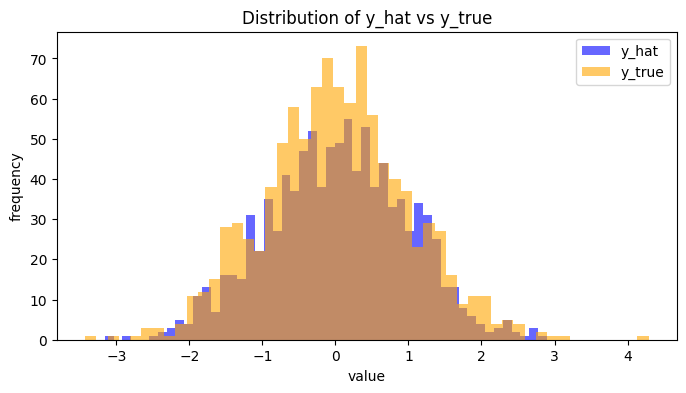

KS: stat=0.034, p=0.61
Epps–Singleton: stat=4.423, p=0.352
t-test (means): stat=0.588, p=0.557
Levene (variances): stat=0.119, p=0.73
y_hat mean= 0.040787414 std= 0.9603412 kurtosis≈ -0.15598392
y_true mean= 0.015096246 std= 0.9935131 kurtosis≈ 0.2949221


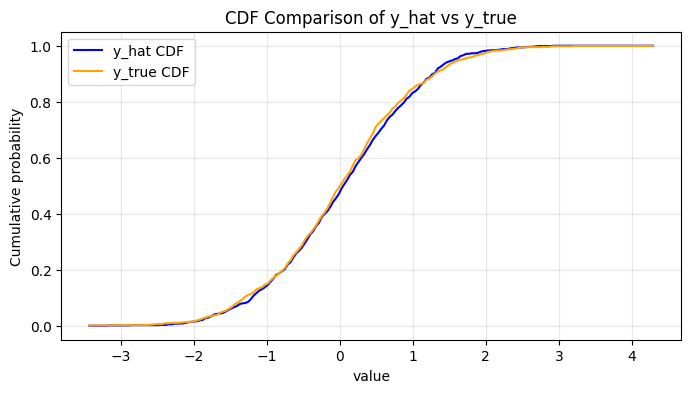

In [3]:
# 在 Jupyter/VS Code 的 notebook 裡
%run "C:\Users\user\OneDrive - 國立陽明交通大學\桌面\001__1141碩士生存指南\536708_機器學習_林得勝\2025Autumn_ML-project-DiffusionModel\20251001_code\First-oneDimTest.ipynb"


In [14]:
def q_sample(x0, t, eps=None):
    # x0: (B,1), t: (B,)
    if eps is None:
        eps = torch.randn_like(x0)
    sa  = sqrt_abar[t].view(-1, 1)       # (B,1)
    slm = sqrt_lmabar[t].view(-1, 1)     # (B,1)
    x_t = sa * x0 + slm * eps
    return x_t, eps

def train_loop(y0: torch.Tensor, train_iters=2000, record_step=1):
    model.train()
    from collections import deque
    losses, movavg, ma = [], [], deque(maxlen=50)

    N = y0.shape[0]
    for step in range(train_iters):
        idx = torch.randint(0, N, (BATCH_SIZE,), device=DEVICE)
        x0  = y0[idx]                                        # ✅ 取出批次 (B,1)
        t   = torch.randint(1, T+1, (BATCH_SIZE,), device=DEVICE).long()

        x_t, eps   = q_sample(x0, t)                         # ✅ 傳 x0 不是 y0
        eps_hat    = model(x_t, t)
        loss       = F.mse_loss(eps_hat, eps)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        if 'scheduler' in globals() and scheduler is not None:
            scheduler.step()

        if step % record_step == 0:
            v = float(loss.detach().item())
            losses.append(v); ma.append(v); movavg.append(sum(ma)/len(ma))

    return losses, movavg


In [15]:
losses, movavg=train_loop(y0, record_step=1)
steps = np.arange(len(losses))

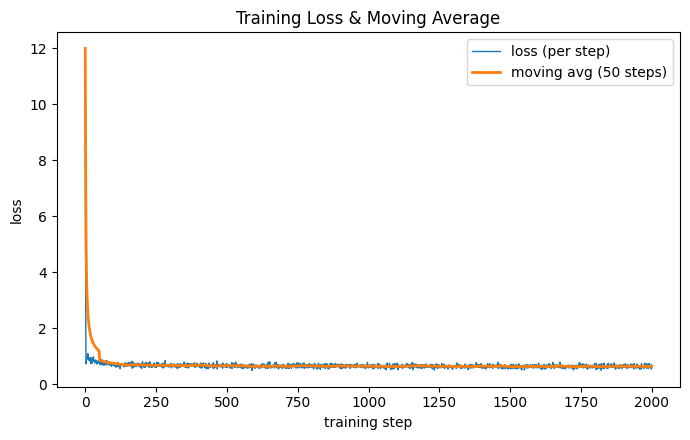

In [16]:
# 全部步數
plt.figure(figsize=(7,4.5))
plt.plot(steps, losses, label="loss (per step)", linewidth=1)
plt.plot(steps, movavg, label="moving avg (50 steps)", linewidth=2)
plt.xlabel("training step")
plt.ylabel("loss")
plt.title("Training Loss & Moving Average")
plt.legend()
plt.tight_layout()
plt.show()


=== Original (y0) vs Reconstructed (x0_hat) ===
mean: 5.0382 vs 5.0021
std : 5.2639 vs 4.7157
KS   : stat=0.0764, p=0.0000
t-test(means): stat=0.5110, p=0.6093
Levene(vars) : stat=727.2035, p=0.0000
Wasserstein-1: 0.6497


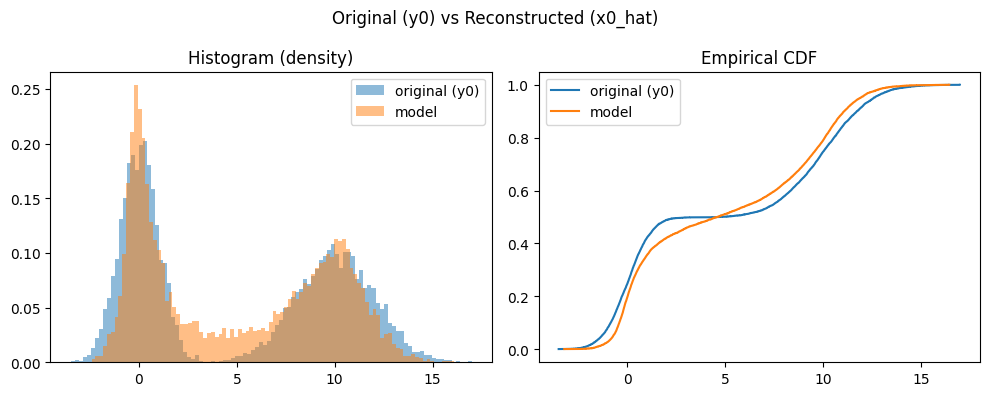

In [18]:
import numpy as np, torch, matplotlib.pyplot as plt
from scipy import stats

# ---------- 1) 重建 x0：用隨機 t 產生 x_t，再用模型預測 eps_hat 反推 ----------
@torch.no_grad()
def reconstruct_x0_with_model(y0: torch.Tensor, n=10000):
    model.eval()
    n = min(n, y0.shape[0])
    idx = torch.randint(0, y0.shape[0], (n,), device=y0.device)
    x0  = y0[idx]                                         # (n,1)
    t   = torch.randint(1, T+1, (n,), device=y0.device)   # (n,)
    eps = torch.randn_like(x0)
    x_t = sqrt_abar[t].unsqueeze(1)*x0 + sqrt_lmabar[t].unsqueeze(1)*eps
    eps_hat = model(x_t, t)
    # 由 x_t、t、eps_hat 估 x0：
    x0_hat = (x_t - sqrt_lmabar[t].unsqueeze(1)*eps_hat) / (sqrt_abar[t].unsqueeze(1)+1e-8)
    return x0_hat

# ---------- 2) 純生成：從 x_T ~ N(0, I) 反向到 0（DDPM 取樣） ----------
@torch.no_grad()
def sample_from_model(n=10000):
    model.eval()
    x_t = torch.randn(n, 1, device=DEVICE)
    for t in range(T, 0, -1):
        tt = torch.full((n,), t, device=DEVICE, dtype=torch.long)
        eps_hat = model(x_t, tt)
        a_t    = alphas[t]; abar_t = abar[t]; beta_t = betas[t]
        abar_tm1 = abar[t-1] if t > 1 else torch.tensor(1.0, device=DEVICE)
        beta_tilde = (1 - abar_tm1) / (1 - abar_t) * beta_t
        mean = (1.0/torch.sqrt(a_t))*(x_t - (beta_t/torch.sqrt(1-abar_t))*eps_hat)
        x_t = mean + (torch.sqrt(beta_tilde)*torch.randn_like(x_t) if t>1 else 0)
    return x_t  # ≈ x0_gen

# ---------- 3) 視覺化 + 統計檢定 ----------
def _to_np(x):
    if isinstance(x, torch.Tensor):
        return x.detach().flatten().cpu().numpy()
    return np.asarray(x).ravel()

def plot_and_tests(ref, cmp, title="compare"):
    A = _to_np(ref); B = _to_np(cmp)

    # 指標
    ks  = stats.ks_2samp(A, B)
    tt  = stats.ttest_ind(A, B, equal_var=False)
    lev = stats.levene(A, B)
    w1  = stats.wasserstein_distance(A, B)

    print(f"\n=== {title} ===")
    print(f"mean: {A.mean():.4f} vs {B.mean():.4f}")
    print(f"std : {A.std(ddof=1):.4f} vs {B.std(ddof=1):.4f}")
    print(f"KS   : stat={ks.statistic:.4f}, p={ks.pvalue:.4f}")
    print(f"t-test(means): stat={tt.statistic:.4f}, p={tt.pvalue:.4f}")
    print(f"Levene(vars) : stat={lev.statistic:.4f}, p={lev.pvalue:.4f}")
    print(f"Wasserstein-1: {w1:.4f}")

    # 圖：Histogram + ECDF
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].hist(A, bins=100, density=True, alpha=0.5, label="original (y0)")
    ax[0].hist(B, bins=100, density=True, alpha=0.5, label="model")
    ax[0].set_title("Histogram (density)"); ax[0].legend()

    xA = np.sort(A); FA = np.arange(1, len(A)+1)/len(A)
    xB = np.sort(B); FB = np.arange(1, len(B)+1)/len(B)
    ax[1].step(xA, FA, where="post", label="original (y0)")
    ax[1].step(xB, FB, where="post", label="model")
    ax[1].set_title("Empirical CDF"); ax[1].legend()

    fig.suptitle(title); fig.tight_layout(); plt.show()

# ---------- 4) 一鍵比較：原分布 vs 重建／生成 ----------
# 確保 y0 是 Tensor 形狀 (N,1)
if not isinstance(y0, torch.Tensor):
    y0 = torch.tensor(y0, dtype=torch.float32, device=DEVICE).unsqueeze(1)

x0_hat = reconstruct_x0_with_model(y0, n=10000)   # 重建
x0_gen = sample_from_model(n=10000)               # 純生成

plot_and_tests(y0, x0_hat, title="Original (y0) vs Reconstructed (x0_hat)")
#plot_and_tests(y0, x0_gen, title="Original (y0) vs Pure Generated (x0_gen)")
